In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numdifftools as nd


import lalsimulation.gwsignal.core.waveform as wfm
import astropy.units as u
from gwpy.frequencyseries import FrequencySeries

from gw_signal_tools.inner_product import optimize_overlap
from gw_signal_tools.waveform_utils import get_wf_generator
from gw_signal_tools.fisher import (
    get_waveform_derivative_1D, get_waveform_derivative_1D_with_convergence,
    fisher_matrix, FisherMatrix
)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/lalsimulation.py:8: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


The pyseobnr package has failed to load, you will not be able to employ SEOBNRv5 approximants.


In [2]:
from gw_signal_tools import PLOT_STYLE_SHEET
plt.style.use(PLOT_STYLE_SHEET)

In [3]:
f_min = 20.*u.Hz  # Cutoff frequency
f_max = 1024. * u.Hz  # Cutoff from PSD
delta_f = 2**-6 * u.Hz
f_ref = f_min  # Frequency where we specify spins


wf_params = {
    'total_mass': 50.*u.Msun,
    # 'mass_ratio': 0.05*u.dimensionless_unscaled,
    # 'mass_ratio': 0.15*u.dimensionless_unscaled,
    'mass_ratio': 0.5*u.dimensionless_unscaled,
    'f22_start': f_min,
    'f_max': f_max,
    'deltaF': delta_f,
    'f22_ref': f_ref,
    'phi_ref': 0.*u.rad,
    # 'distance': 1.*u.Mpc,
    'distance': 440.*u.Mpc,  # As expected, systematic error is independent of SNR and thus amplitude given by D_L
    'inclination': 0.*u.rad,
    'eccentricity': 0.*u.dimensionless_unscaled,
    'longAscNodes': 0.*u.rad,
    'meanPerAno': 0.*u.rad,
    'condition': 0
}

In [25]:
# Make sure mass1 and mass2 are not in default_dict (makes messy behaviour)
import lalsimulation.gwsignal.core.parameter_conventions as pc
pc.default_dict.pop('mass1', None);
pc.default_dict.pop('mass2', None);

## Recovering $t_0$-Bias

In [5]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [6]:
t_shift = 1e-3*u.s

def shifted_wf_gen(wf_params):
    wf = ref_generator(wf_params)
    return wf * np.exp(-2.j*np.pi*wf.frequencies*t_shift)

In [7]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params,
    ref_generator,
    shifted_wf_gen,
    opt_params=['time', 'phase'],
    # opt_params=['time'],
    min_dt_prec=1e-5
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [8]:
fisher_t_bias = FisherMatrix(
    wf_params,
    ['time', 'phase'],
    # 'time',
    shifted_wf_gen,
    direct_computation=False,
    min_dt_prec=1e-5*u.s
)

sys_error_t_bias_non_opt = fisher_t_bias.systematic_error(
    ref_generator,
    optimize=False
)


sys_error_t_bias_opt, opt_info = fisher_t_bias.systematic_error(
    ref_generator,
    # optimize=['time', 'phase']
    optimize=['time']
    # Results for both choices are equal
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [9]:
print(t_shift)
print(opt_params['time'])
print(sys_error_t_bias_non_opt[0,0])
print(sys_error_t_bias_opt[0,0])

0.001 s
-0.00099945068359375 1 / Hz
-0.0005971830525189386 s
-0.0009999999999211048 s


In [10]:
t_shift_from_opt = []
t_bias_non_opt = []
t_bias_opt = []

t_shifts = np.linspace(1e-6, 1e-2, num=16)*u.s


wf1 = ref_generator(wf_params)

for shift in t_shifts:
    def shifted_wf_gen(wf_params):
        wf = ref_generator(wf_params)
        return wf * np.exp(-2.j*np.pi*wf.frequencies*shift)

    # _, _, opt_params = optimize_overlap(
    #     wf_params,
    #     ref_generator,
    #     shifted_wf_gen,
    #     opt_params=['time', 'phase'],
    #     min_dt_prec=1e-5*u.s
    # )

    # t_shift_from_opt += [
    #     opt_params['time'].value  # Otherwise error when reshaping
    # ]
    # Kind of unnecessary, optimization in sys error does same
    
    fisher = FisherMatrix(
        wf_params,
        ['time', 'phase'],
        # 'time',
        shifted_wf_gen,
        direct_computation=False,
        min_dt_prec=1e-5*u.s
    )
    
    t_bias_non_opt += [
        fisher.systematic_error(
            ref_generator,
            'time',
            optimize=False
        )
    ]
    
    t_bias_opt += [
        fisher.systematic_error(
            ref_generator,
            'time',
            # optimize=True,  # Equivalent, but less explicit than below
            optimize=['time', 'phase'],
            return_opt_info=False
        )
    ]

t_bias_non_opt = np.reshape(t_bias_non_opt, -1)
t_bias_opt = np.reshape(t_bias_opt, -1)
t_shift_from_opt = np.reshape(t_shift_from_opt, -1)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

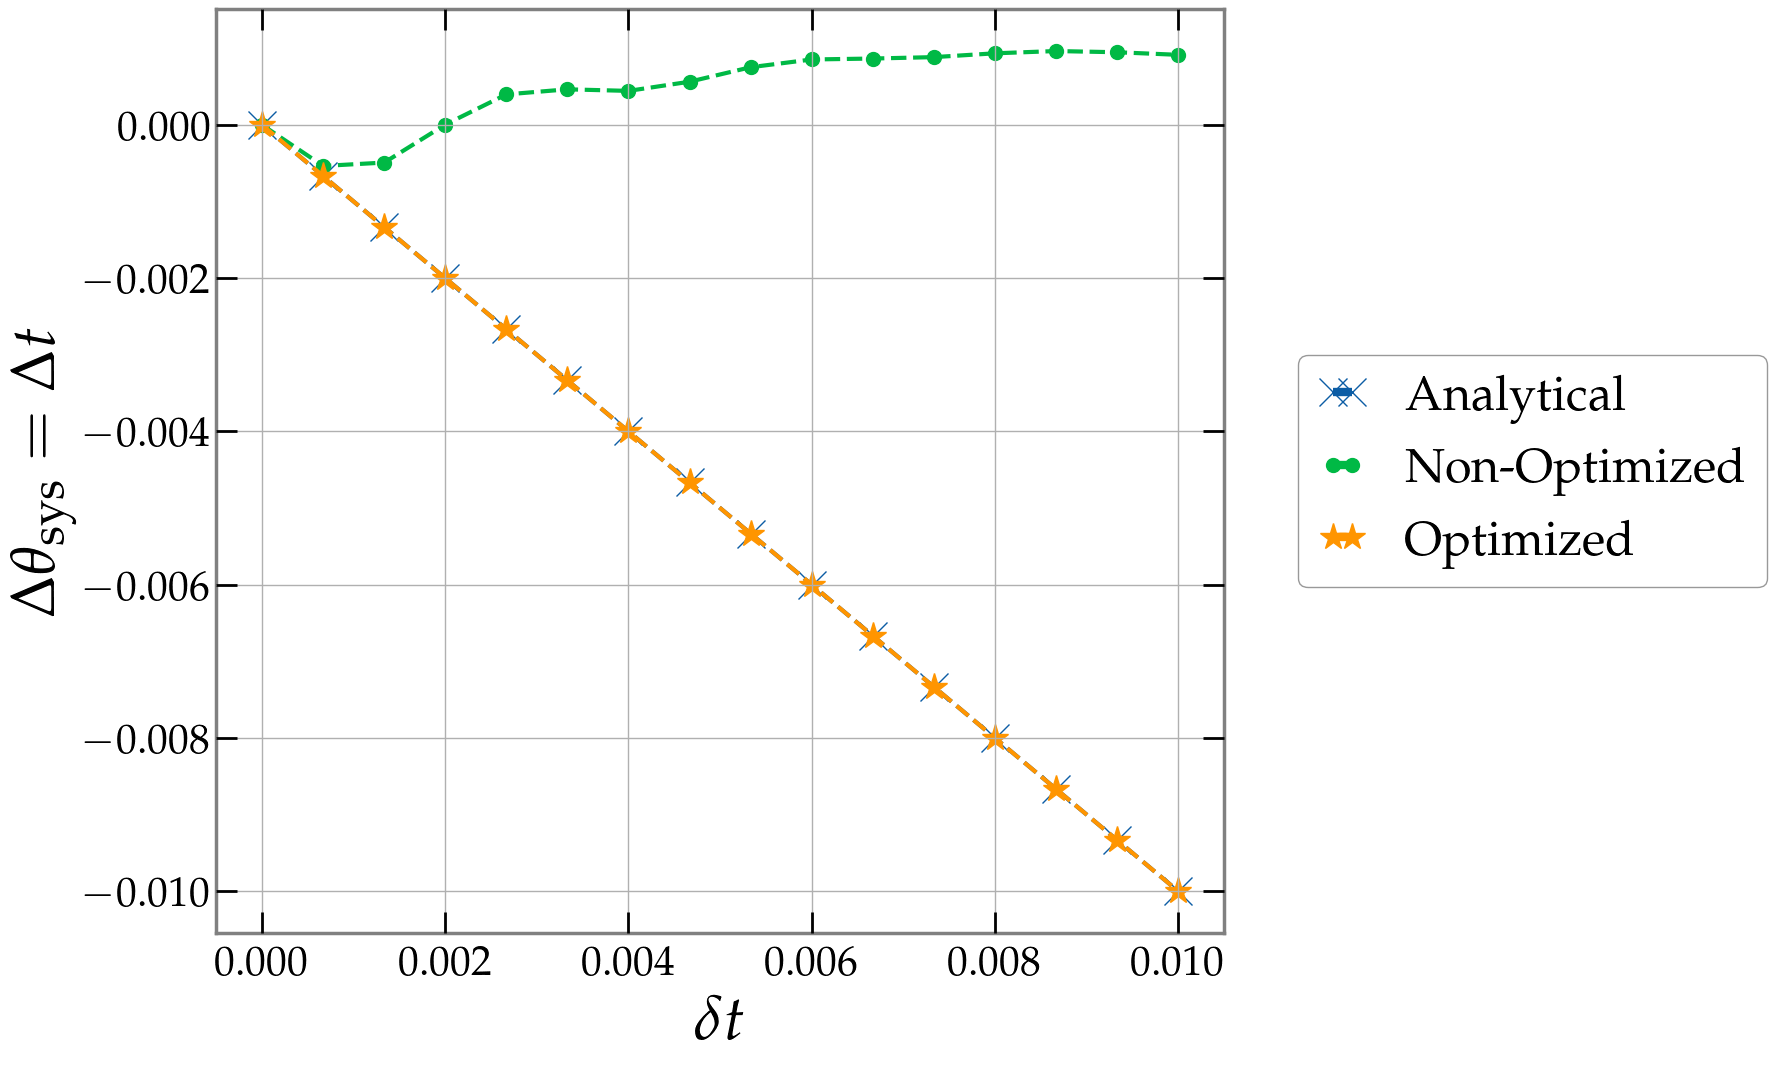

In [24]:
plt.plot(t_shifts, -t_shifts, 'x--', label='Analytical')
# plt.plot(t_shifts, t_shift_from_opt, '+--', label='Optimization Routine')
plt.plot(t_shifts, t_bias_non_opt, '.--', label='Non-Optimized')
plt.plot(t_shifts, t_bias_opt, '*--', label='Optimized')

plt.xlabel(r'$\delta t$')
plt.ylabel(r'$\Delta \theta_\mathrm{sys} = \Delta t$')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.show()

## Recovering $M$-Bias

In [5]:
ref_model = 'IMRPhenomXPHM'

ref_generator = get_wf_generator(ref_model)

/home/user/miniconda3/envs/gw_signal_tools_light/lib/python3.11/site-packages/lalsimulation/gwsignal/core/waveform.py:226: UserWarning: This code is currently UNREVIEWED, use with caution!
  warnings.warn("This code is currently UNREVIEWED, use with caution!")


In [6]:
M_shift = 0.2*u.Msun
# M_shift = 2.*u.Msun

def shifted_wf_gen(wf_params):
    return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - M_shift})

In [7]:
wf1_shifted, wf2_shifted, opt_params = optimize_overlap(
    wf_params,
    ref_generator,
    shifted_wf_gen,
    # opt_params=['total_mass']
    opt_params=['total_mass', 'time', 'phase']
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

When including time and phase in the optimization, the mismatch as a function of $M$-shift is much smoother and does not oscillate, so that higher shifts can be recovered.

In [8]:
fisher_M_bias = FisherMatrix(
    wf_params,
    # 'total_mass',
    ['total_mass', 'time', 'phase'],
    shifted_wf_gen,
    direct_computation=False
)

sys_error_M_bias_non_opt = fisher_M_bias.systematic_error(
    ref_generator,
    optimize=False
)


sys_error_M_bias_opt, opt_info = fisher_M_bias.systematic_error(
    ref_generator,
    optimize=['time', 'phase']
)


sys_error_M_bias_M_opt, M_opt_info = fisher_M_bias.systematic_error(
    ref_generator,
    optimize=['total_mass', 'time', 'phase']
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

In [9]:
print(M_shift)
print(opt_params['total_mass'] - wf_params['total_mass'])
print(sys_error_M_bias_non_opt[0,0])
print(sys_error_M_bias_opt[0,0])
print(sys_error_M_bias_M_opt[0,0])

0.2 solMass
0.1999664306640625 solMass
0.18654706181471803 solMass
0.1970367286180362 solMass
0.20000058807398127 solMass


All of these shifts are equal to the expected shift of $$\Delta \theta_\mathrm{sys} = \theta_\mathrm{bf} - \theta_\mathrm{true} = 0.2$$

We can see that this is the correct result by remembering that the injected reference signal has $M = 50 M_\odot$. The biased model will achieve the best fit with this when it returns the waveform for $M = 50 M_\odot$, which is the case for input $50 M_\odot + \text{shift}$. This is nothing but the $M$-component of $\theta_\mathrm{bf}$.

In [17]:
M_shift_from_opt = []
M_bias_non_opt = []
M_bias_opt = []
M_bias_M_opt = []

M_shifts = np.linspace(0.2, 2., num=10)*u.Msun


wf1 = ref_generator(wf_params)

for shift in M_shifts:
    def shifted_wf_gen(wf_params):
        return ref_generator(wf_params | {'total_mass': wf_params['total_mass'] - shift})

    _, _, opt_params = optimize_overlap(
        wf_params,
        ref_generator,
        shifted_wf_gen,
        # opt_params=['total_mass']
        opt_params=['total_mass', 'time', 'phase']
    )

    M_shift_from_opt += [
        (opt_params['total_mass'] - wf_params['total_mass']).value  # Otherwise error when reshaping
    ]
    # Kind of unnecessary, optimization in sys error does same
    
    fisher_M_bias = FisherMatrix(
        wf_params,
        # 'total_mass',
        ['total_mass', 'time', 'phase'],
        shifted_wf_gen,
        direct_computation=False
    )

    M_bias_non_opt += [
        fisher_M_bias.systematic_error(
            ref_generator,
            'total_mass',
            optimize=False
        )
    ]

    M_bias_opt += [
        fisher_M_bias.systematic_error(
            ref_generator,
            'total_mass',
            optimize=['time', 'phase'],
            return_opt_info=False
        )
    ]

    M_bias_M_opt += [
        fisher_M_bias.systematic_error(
            ref_generator,
            'total_mass',
            optimize=['total_mass', 'time', 'phase'],
            return_opt_info=False
        )
    ]

M_shift_from_opt = np.reshape(M_shift_from_opt, -1)
M_bias_non_opt = np.reshape(M_bias_non_opt, -1)
M_bias_opt = np.reshape(M_bias_opt, -1)
M_bias_M_opt = np.reshape(M_bias_M_opt, -1)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

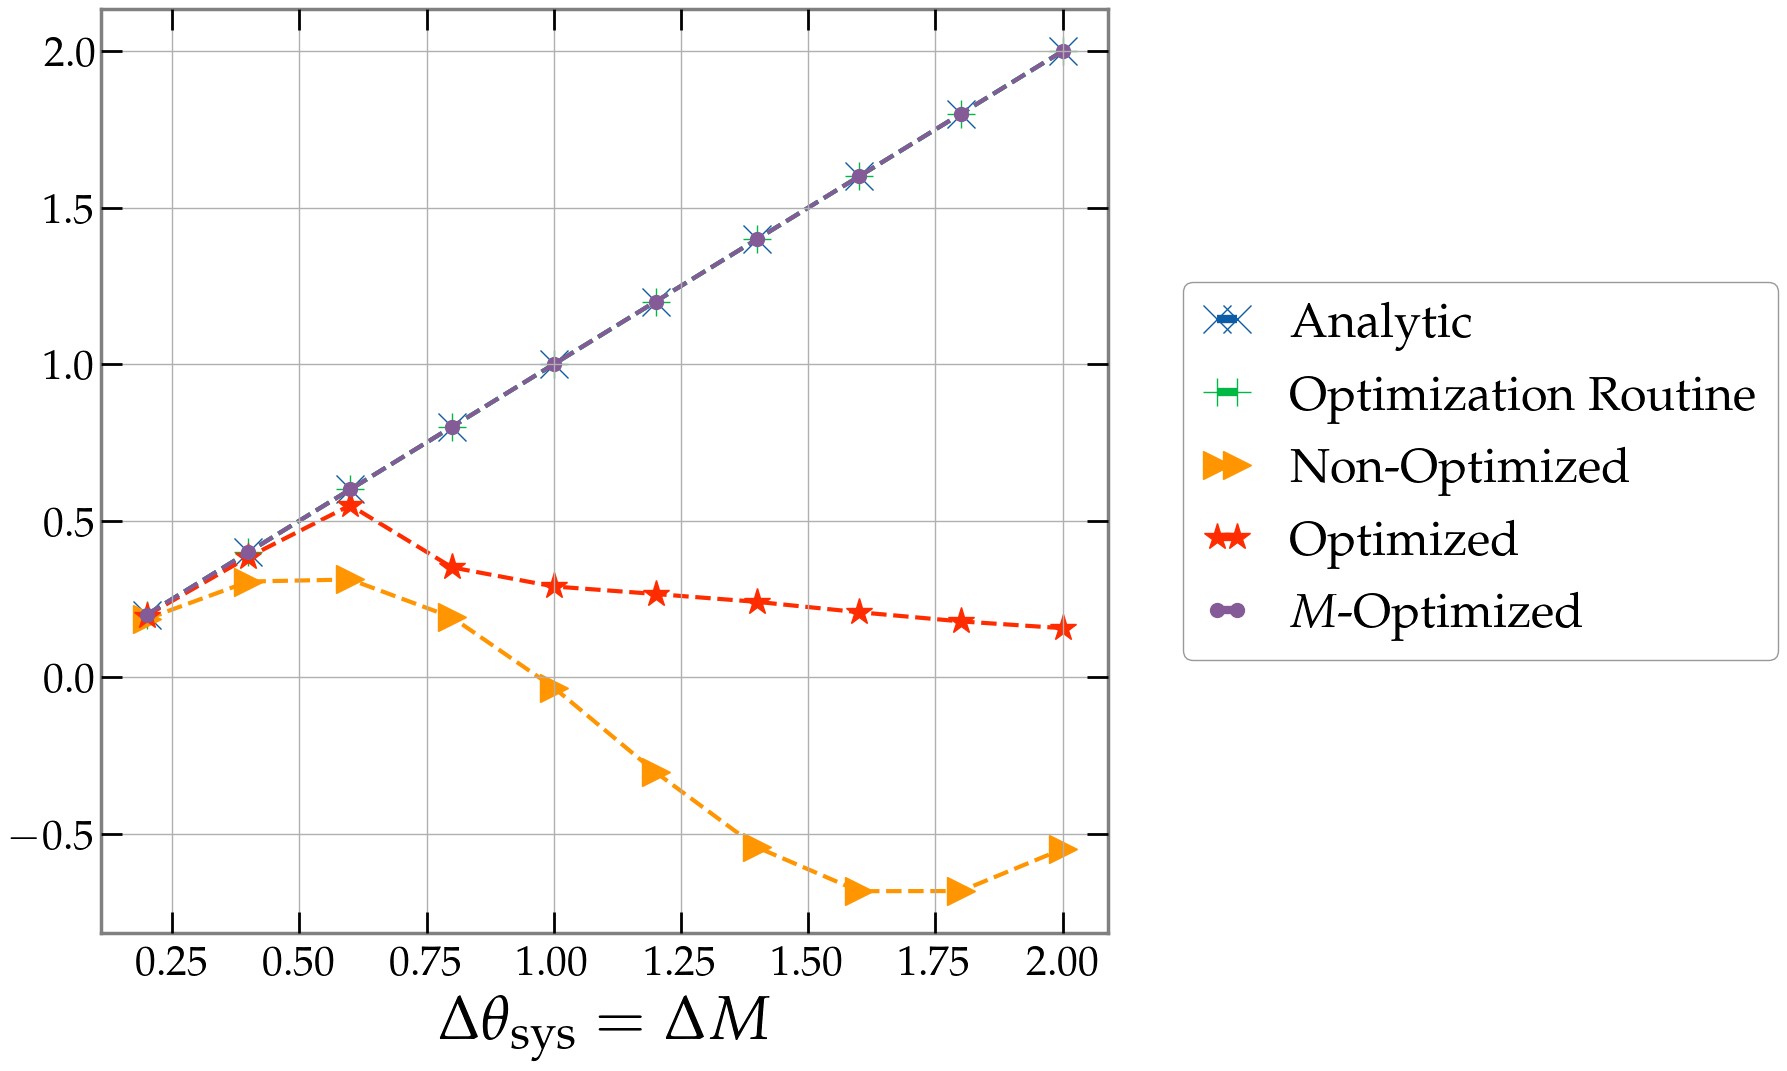

In [23]:
plt.plot(M_shifts, M_shifts, 'x--', label='Analytic')
plt.plot(M_shifts, M_shift_from_opt, '+--', label='Optimization Routine')
plt.plot(M_shifts, M_bias_non_opt, '>--', label='Non-Optimized')
plt.plot(M_shifts, M_bias_opt, '*--', label='Optimized')
plt.plot(M_shifts, M_bias_M_opt, '.--', label='$M$-Optimized')

plt.xlabel(r'$\delta M$')
plt.xlabel(r'$\Delta \theta_\mathrm{sys} = \Delta M$')
plt.legend(bbox_to_anchor=(1.05, 0.5), loc='center left')

plt.show()

## Benchmarking

In [10]:
import cProfile

In [11]:
cProfile.run(
    '''optimize_overlap(
        wf_params,
        ref_generator,
        shifted_wf_gen,
        # opt_params=['total_mass']
        opt_params=['total_mass', 'time', 'phase']
    )''',
    sort=1
)

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is

         960746 function calls (952825 primitive calls) in 13.775 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
       34    5.161    0.152    5.170    0.152 {built-in method lalsimulation._lalsimulation.SimInspiralGenerateFDWaveform}
      646    2.599    0.004    2.599    0.004 {built-in method lal._lal.DictInsertREAL8Value}
       68    0.526    0.008    0.782    0.011 array.py:319(epoch)
       34    0.415    0.012   10.597    0.312 waveform.py:334(generate_fd_waveform)
       68    0.290    0.004    0.290    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedTDApproximants}
       68    0.265    0.004    0.265    0.004 {built-in method lalsimulation._lalsimulation.SimInspiralImplementedFDApproximants}
       68    0.262    0.004    1.095    0.016 waveform.py:525(to_gwpy_Series)
       97    0.255    0.003    0.255    0.003 {built-in method numpy.fft._pocketfft_internal.execute}
       68    0.2

XLAL Warning - XLALSimInspiralWaveformParamsLookupMass1 (LALSimInspiralWaveformParams.c:490): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMassRatio (LALSimInspiralWaveformParams.c:851): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupMass2 (LALSimInspiralWaveformParams.c:669): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralCheckDeterminationOfMasses (LALSimInspiralWaveformParams.c:87): This code is currently UNREVIEWED, use with caution!
XLAL Warning - XLALSimInspiralWaveformParamsLookupTotalMass (LALSimInspiralWaveformParams.c:833): This code is